# Retrieve Data

Grabbing WebIDs ...
WebID collection complete!
13:54:08: Sending API request... Chunk 1 of 1
13:54:09: Response recieved for 1 tags! (0.93)


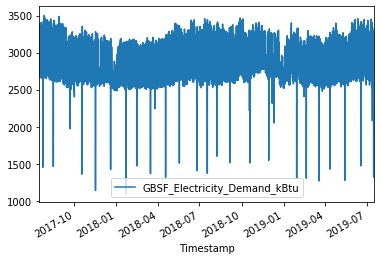

In [49]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "07-17-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df = df.dropna()
df.plot()


# Add New Variables

                     GBSF_Electricity_Demand_kBtu  rolling_ten  \
Timestamp                                                        
2017-07-17 00:00:00                   2718.246116  2718.246116   
2017-07-17 01:00:00                   2706.419560  2712.332838   
2017-07-17 02:00:00                   2714.511580  2713.059085   
2017-07-17 03:00:00                   2695.350942  2708.632050   
2017-07-17 04:00:00                   2684.286365  2703.762913   

                     rolling_twenty  rolling_thirty  
Timestamp                                            
2017-07-17 00:00:00     2718.246116     2718.246116  
2017-07-17 01:00:00     2712.332838     2712.332838  
2017-07-17 02:00:00     2713.059085     2713.059085  
2017-07-17 03:00:00     2708.632050     2708.632050  
2017-07-17 04:00:00     2703.762913     2703.762913  


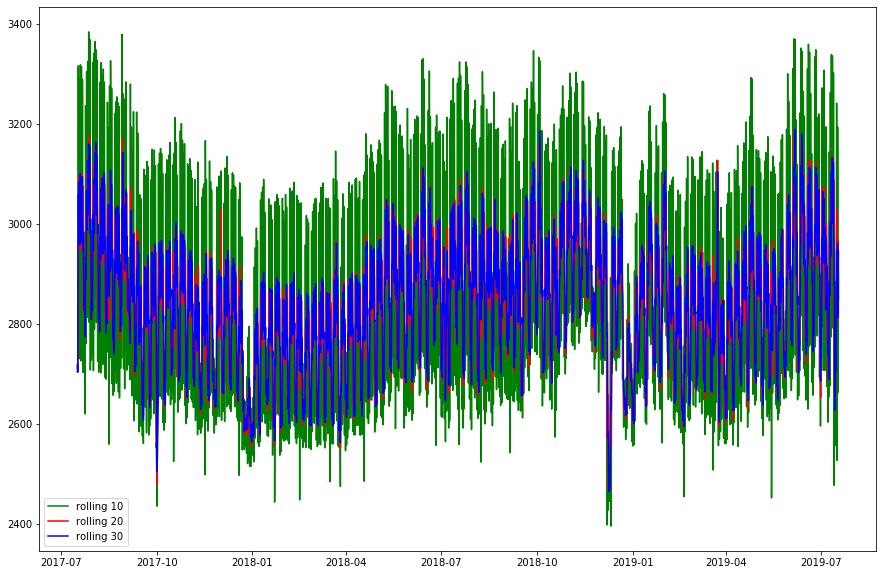

In [50]:
#add a rolling 10 and a rolling 20 mean, as well as a rolling 30
#these look at the past 10, 20, or 30 values (including the current point) and use the mean of those numbers
from functools import reduce


rolling_ten = df.rolling(window=10, min_periods=1).mean()
rolling_twenty = df.rolling(window=20, min_periods=1).mean()
rolling_thirty = df.rolling(window=30, min_periods=1).mean()

#merge new variables
df['rolling_ten'] = rolling_ten.values
df['rolling_twenty'] = rolling_twenty.values
df['rolling_thirty'] = rolling_thirty.values

print(df.head(5))

plt.figure(figsize = (15, 10))
plt.plot(rolling_ten.index, rolling_ten.values, color = 'green', label = 'rolling 10')
plt.plot(rolling_twenty.index, rolling_twenty.values, color = 'red', label = 'rolling 20')
plt.plot(rolling_thirty.index, rolling_thirty.values, color = 'blue', label = 'rolling 30')
plt.legend(loc = 'best')
plt.show()





# Split Into Training + Testing

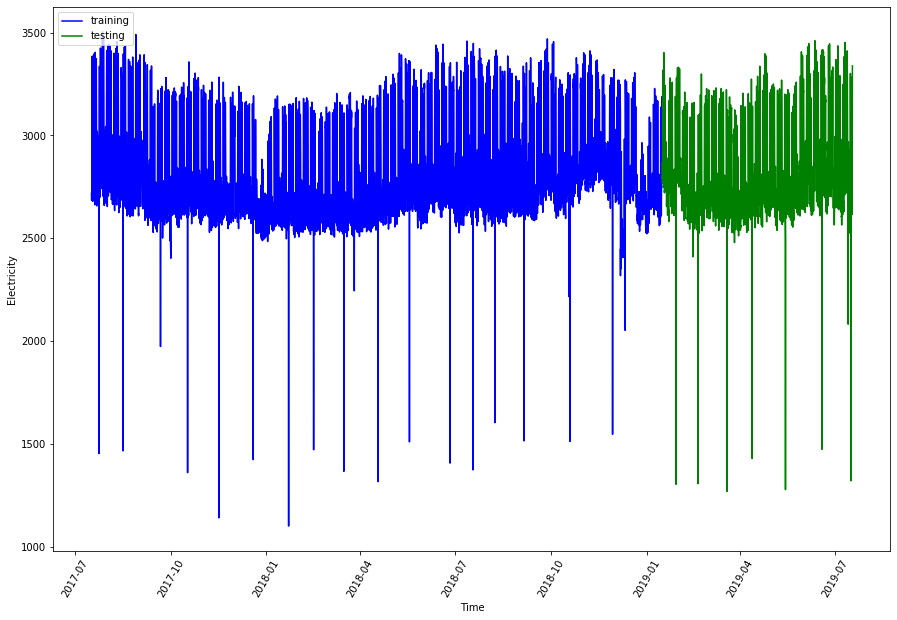

In [70]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, [1, 2, 3]]
y = df.iloc[:, [0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
#plot the electricity data that was put into training - y_train, y_test
plt.figure(figsize = (15, 10))
plt.plot(y_train.index, y_train.values, color = 'blue', label = 'training')
plt.plot(y_test.index, y_test.values, color = 'green', label = 'testing')
plt.xticks(rotation=60)
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.legend(loc = 'upper left')
plt.show()




#evaluate accuracy
#compare to rf
#re-fit best model to dataset
#plot of original elec, fitted values
#plot of resids from that
#plot of outliers from that
#plot of data without outliers

# Fit Models and Compare Accuracy

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 4, 6, 8, 10]}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(gb, param_grid, cv = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#refit model with best parameters
new_gb = GradientBoostingRegressor(n_estimators = 100, min_samples_split = 6)
new_gb.fit(X_train, y_train)
print("Gradient Boosting Regressor accuracy:", new_gb.score(X_test, y_test))



#compare to rf
#fit with the same best params
rf = RandomForestRegressor(n_estimators=100, min_samples_split = 6)
rf.fit(X_train, y_train)
print("Random Forest Regressor Accuracy:", rf.score(X_test, y_test))


{'min_samples_split': 6, 'n_estimators': 100}
Gradient Boosting Regressor accuracy: 0.6826061772530999
Random Forest Regressor Accuracy: 0.7280491363606882


# Fit Best Model to Whole Dataset

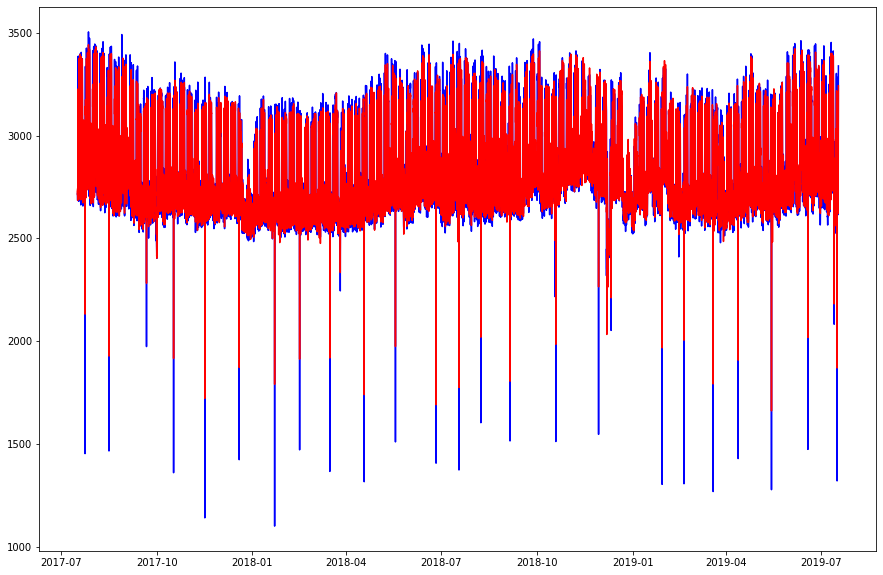

In [82]:
rf = RandomForestRegressor(n_estimators=100, min_samples_split = 6)
rf.fit(X, y)
preds = rf.predict(X)
actual_series = y
pred_series = pd.Series(preds, index = actual_series.index)
plt.figure(figsize = (15, 10))
plt.plot(actual_series.index, actual_series.values, color = 'blue', label = 'actual')
plt.plot(pred_series.index, pred_series.values, color = 'red', label = 'predicted')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.show()

# Extract Residuals From Model Fit

Text(0, 0.5, 'Frequency')

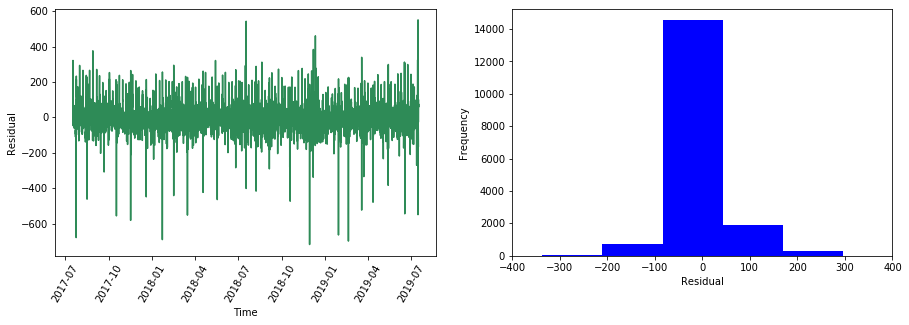

In [110]:
actual = np.ravel(np.array(actual_series.values.tolist()))
actual = list(actual)
preds = pred_series.values.tolist()
resids = [actual[i] - preds[i] for i in range(len(actual))]
resid_series = pd.Series(resids, index = actual_series.index)
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(resid_series.index, resid_series.values, color = 'seagreen')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.xticks(rotation=60)
plt.subplot(2, 2, 2)
#a histogram of the residuals
plt.hist(resids, color = 'b', bins = 10)
plt.xlim([-400, 400])
plt.xlabel("Residual")
plt.ylabel("Frequency")

# Determine Threshold For Residual Outlier